# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [1]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import urllib.request
import sklearn
import sklearn.linear_model
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron

In [3]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [4]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
    
        idx = self.word2id[word]  # Index of the given word
    
        return self.embeddings[idx]  
        
    
    def score(self, word1, word2):
        # Returns the cosine similarity: use np.dot & np.linalg.norm
        # Get embedding of both words
        embed1 = self.encode(word1)
        embed2 = self.encode(word2)
        
        # Compute cosine similarity
        cosine_similarity = np.dot(embed1,embed2) / (np.linalg.norm(embed1)*np.linalg.norm(embed2))  
        
        return cosine_similarity
    
    def most_similar(self, word, k=5):
        # Return the k most similar vector embeddings to the vector embedding of 'word'
        scores = []  
        
        # Build a list of cosine similarities between the given word and the other words in the vocabulary
        for word_prime, index in self.word2id.items():      
            scores.append(self.score(word,word_prime))      # Note: Includes the cosine similarity with itself
        
        # Returns the indices that would sort the list of scores in the descending order
        scores = np.array(scores)  
        scores_index_sorted = np.argsort(-scores)    
        
        # k most similar vector embeddings, from most similar to least similar
        k_most_similar = [self.id2word[scores_index_sorted[i]] for i in range(1,k+1)]
        
        return k_most_similar

In [5]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats', 'kitty', 'kitten', 'feline', 'dog']
['dogs', 'puppy', 'pup', 'canine', 'pet']
['dog', 'cats', 'puppies', 'Dogs', 'pets']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria']


In [8]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        num_sentences = len(sentences)
        word2idf = {}
        
        # Compute the number of sentences containing the word, associated to each word
        for word, index in self.word2vec.word2id.items():
            word2idf[word] = 0
            for sentence in sentences:
                if word in sentence:
                    word2idf[word] += 1
        
        # Compute the Inverse Document Frequency IDF
        for word, value in word2idf.items():
            if word2idf[word] > 0:
                word2idf[word] = np.log(num_sentences / word2idf[word])
        
        return word2idf
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        sentence = sentence.split(' ') # Convert sentence to list of words
        sentence_vocab = [] 
        mean = 0
        
        # Build the list of words in the sentence also contained in the vocabulary
        for word in sentence:
            if word in self.word2vec.words:
                sentence_vocab.append(word)
        
        if len(sentence_vocab) == 0:
            return mean
        
        else:
            if idf is None:
                # mean of word vectors
                # Compute mean of word embeddings
                for word in sentence_vocab:
                        mean += word2vec.encode(word)
                
                sentence_embed = mean / len(sentence_vocab)
        
            else:
                # idf-weighted mean of word vectors
                for word in sentence_vocab:
                    mean += idf[word]*word2vec.encode(word)
            
                sentence_embed = mean / len(sentence_vocab)
            
        return sentence_embed

    def score(self, sentence1, sentence2, idf=None):
        # Cosine similarity: use np.dot & np.linalg.norm 
        embed1 = self.encode(sentence1)
        embed2 = self.encode(sentence2)
        
        # Compute cosine similarity
        cosine_similarity = np.dot(embed1,embed2) / (np.linalg.norm(embed1)*np.linalg.norm(embed2))
        
        return cosine_similarity
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        scores = []  
        
        # Build a list of cosine similarities between the given sentence and the other sentences
        for sentence_prime in sentences:
            scores.append(self.score(sentence,sentence_prime))
            
        # Returns the indices that would sort the list of scores in the descending order
        scores = np.array(scores)
        scores_index_sorted = np.argsort(-scores)    
        
        # List of the k sentences with the most similar vector embeddings, from most similar to least similar
        k_most_similar = [sentences[scores_index_sorted[i]] for i in range(1,k+1)]
        
        
        return k_most_similar

In [9]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
1 smiling african american boy . 
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251475
a young boy and 2 girls open christmas presents . 
1) a small boy following 4 geese . 
2) a woman walking with 4 kids . 
3) 2 older women and a young girl with a red bike . 
4) two girls and a boy rollerskating . 
5) a youthful race against 2 asian kids . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [10]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        identical_words = []   
        
        # Build a list containing the identical character strings
        for word in fr_word2vec.words:
            if word in en_word2vec.words:
                identical_words.append(word)
        
        
        # Build Embeddings matrix (of identical words)
        m = len(identical_words)
        n = len(fr_word2vec.encode(identical_words[0]))
        X = np.zeros((n,m))
        Y = np.zeros((n,m))
        
        
        for idx, word in enumerate(identical_words):
                X[:,idx] = self.fr_word2vec.encode(word)
                Y[:,idx] = self.en_word2vec.encode(word)
                
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        U, S, V = np.linalg.svd(Y.dot(X.T))
        W_optimal = U.dot(V)
    
    
        assert W_optimal.shape == (300, 300)
        
       
        return np.matmul(fr_word2vec.embeddings, W_optimal.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        index = self.fr_word2vec.word2id[fr_word]
        aligned_fr_word = self.aligned_fr_embeddings[index,:]   # Aligned embedding of fr_word
        scores = []
        
        
        # Build a list of euclidean distances between the aligned embedding of fr_word and en_words
        for en_word_embedding in en_word2vec.embeddings:
            cosine_similarity = np.dot(en_word_embedding,aligned_fr_word) / (np.linalg.norm(en_word_embedding)*np.linalg.norm(aligned_fr_word))
            scores.append(cosine_similarity)
         
        
        # Get the indices that would sort the list of scores in the descending order
        scores = np.array(scores)
        scores_index_sorted = np.argsort(-scores)
        
        # List of the k en_words with the closest vector embedding, from closest to least similar
        k_nearest_neighbors = [en_word2vec.words[scores_index_sorted[i]] for i in range(0,k+1)]
        
            
        return k_nearest_neighbors

In [11]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "cat"
en: "kitten"
en: "kitty"
en: "pet"
----------
fr: "chien"
en: "dog"
en: "cat"
en: "pet"
en: "pup"
----------
fr: "voiture"
en: "car"
en: "vehicle"
en: "automobile"
en: "motorbike"
----------
fr: "zut"
en: "oops"
en: "Ah"
en: "ah"
en: "nope"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [14]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# Process file
def process(file):
    
    sentences =[]
    labels = []
    for line in file:
        num = line.split()
        labels.append(int(num[0]))
        sentence = " " 
        sentence = sentence.join(num[1:-1])
        sentences.append(sentence)
        
        
    return sentences, labels

# Process file (To process test file)
def process_test(file):
    
    sentences =[]
    labels = []
    for line in file:
        num = line.split()
        sentence = " "
        sentence = sentence.join(num[0:-1])
        sentences.append(sentence)
        
        
    return sentences

# Process Data
file_train = open(train_filepath, 'r')
train_sentences, train_labels = process(file_train)
file_train.close()
file_dev = open(dev_filepath, 'r')
dev_sentences, dev_labels = process(file_dev)
file_dev.close()
file_test = open(test_filepath, 'r')
test_sentences = process_test(file_test)
file_test.close()
file_test = open(test_filepath, 'r')
test_sentences_copy = process_test(file_test)
file_test.close()

In [15]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

out_indexes = []   # List of index where the associated sentence(in the test set) contains no words in the
                    # vocabulary and thus has no valid sentence embedding


# Get rid of the sentences containing no words in the vocabulary
# Train set
for idx,sentence in enumerate(train_sentences):
    if np.linalg.norm(sentence2vec.encode(sentence)) == 0:
        del train_sentences[idx]
        del train_labels[idx]

# Evaluation set
for idx,sentence in enumerate(dev_sentences):
    if np.linalg.norm(sentence2vec.encode(sentence)) == 0:
        del dev_sentences[idx]
        del dev_labels[idx]
    
        
# Test set
corr=0
for idx,sentence in enumerate(test_sentences_copy):
    if np.linalg.norm(sentence2vec.encode(sentence)) == 0:
        test_sentences.pop(idx-corr)
        out_indexes.append(idx)
        corr += 1
       
    

# Build the idf dictionnary with sentences from train, eval and test set
sentences = [*train_sentences, *dev_sentences, *test_sentences]
idf = sentence2vec.build_idf(sentences)

train_idf_embeddings = []
dev_idf_embeddings = []
train_embeddings = []
dev_embeddings = []
test_idf_embeddings = []
test_embeddings = []

# Build the list of sentence embeddings with idf
# Train set
for sentence in train_sentences:
    train_idf_embeddings.append(sentence2vec.encode(sentence,idf))

# Evaluation set
for sentence in dev_sentences:
    dev_idf_embeddings.append(sentence2vec.encode(sentence,idf))

# Test set
for sentence in test_sentences:
    test_idf_embeddings.append(sentence2vec.encode(sentence,idf))
    
# Build the list of sentence embeddings without idf
# Train set
for sentence in train_sentences:
    train_embeddings.append(sentence2vec.encode(sentence))
    
# Evaluation set    
for sentence in dev_sentences:
    dev_embeddings.append(sentence2vec.encode(sentence))
    
# Test set    
for sentence in test_sentences:
    test_embeddings.append(sentence2vec.encode(sentence))

Loaded 50000 pretrained word vectors


Without IDF weights:

Training accuracy with c = 0.05: 27.21%
Validation accuracy with c = 0.05: 25.34%

Training accuracy with c = 0.10: 27.82%
Validation accuracy with c = 0.10: 26.70%

Training accuracy with c = 0.15: 32.27%
Validation accuracy with c = 0.15: 31.70%

Training accuracy with c = 0.20: 33.83%
Validation accuracy with c = 0.20: 33.24%

Training accuracy with c = 0.25: 35.36%
Validation accuracy with c = 0.25: 34.42%

Training accuracy with c = 0.30: 36.90%
Validation accuracy with c = 0.30: 35.06%

Training accuracy with c = 0.35: 38.03%
Validation accuracy with c = 0.35: 35.79%

Training accuracy with c = 0.40: 38.68%
Validation accuracy with c = 0.40: 36.06%

Training accuracy with c = 0.45: 39.61%
Validation accuracy with c = 0.45: 37.06%

Training accuracy with c = 0.50: 40.09%
Validation accuracy with c = 0.50: 37.60%

Training accuracy with c = 0.55: 40.44%
Validation accuracy with c = 0.55: 38.33%

Training accuracy with c = 0.60: 41.04%
Validation accuracy with 

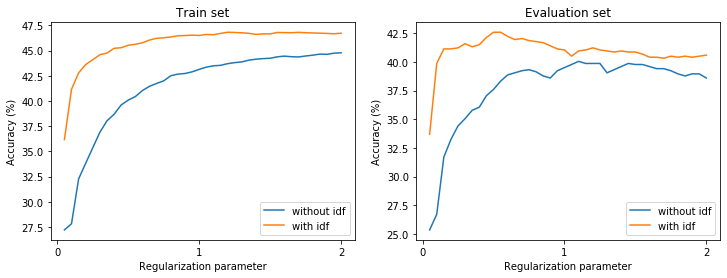

In [50]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# Convert list to array to use scikit-learn
train_embeddings = np.stack(train_embeddings, axis=0 )
train_labels = np.array(train_labels)
dev_embeddings = np.stack(dev_embeddings,axis=0)
dev_labels = np.array(dev_labels)

hyp_para = np.linspace(0.05,2,40)  # parameters for tuning
hyp_para.tolist()
train_scores_idf = []
train_scores = []
dev_scores_idf = []
dev_scores = []

i = 0
print('Without IDF weights:\n')
# Compute score on dev set for each regularization parameter 
for c in hyp_para:
    LogReg = sklearn.linear_model.LogisticRegression(penalty='l1', tol= 0.0001, C=c, multi_class='auto')
    LogReg.fit(train_embeddings, train_labels)
    train_scores.append(LogReg.score(train_embeddings, train_labels))
    dev_scores.append(LogReg.score(dev_embeddings,dev_labels))
    print('Training accuracy with c = {:.2f}: {:.2f}%'.format(c, 100*train_scores[i]))
    print('Validation accuracy with c = {:.2f}: {:.2f}%\n'.format(c, 100*dev_scores[i]))
 
    i += 1
    
print
    
    
i = 0   
print('With IDF weights:\n')
for c in hyp_para:
    LogReg = sklearn.linear_model.LogisticRegression(penalty='l1', tol= 0.0001, C=c, multi_class='auto')
    LogReg.fit(train_idf_embeddings, train_labels)
    train_scores_idf.append(LogReg.score(train_idf_embeddings, train_labels))
    dev_scores_idf.append(LogReg.score(dev_idf_embeddings,dev_labels))
    print('Training accuracy with c = {:.2f}: {:.2f}%'.format(c, 100*train_scores_idf[i]))
    print('Validation accuracy with c = {:.2f}: {:.2f}%\n'.format(c, 100*dev_scores_idf[i]))
    i += 1
    
# Note: also tried with the l2 penalty and several other tolerance rates and I got the best result with this
# configuaration
    
# To array
train_scores_idf = np.array(train_scores_idf)
dev_scores_idf = np.array(dev_scores_idf)
train_scores = np.array(train_scores)
dev_scores = np.array(dev_scores)

# Optimal regularization parameter
c_idf_optimal = hyp_para[np.argmax(dev_scores_idf)]
c_optimal = hyp_para[np.argmax(dev_scores)]

# Optimal scores
score_train_idf_optimal = np.max(train_scores_idf)
score_dev_idf_optimal = np.max(dev_scores_idf)
score_train_optimal = np.max(train_scores)
score_dev_optimal = np.max(dev_scores)

# Plot
# data
train_accuracy = [100*ele for ele in train_scores]
train_accuracy_idf = [100*ele for ele in train_scores_idf]
val_accuracy = [100*ele for ele in dev_scores]
val_accuracy_idf = [100*ele for ele in dev_scores_idf]
x_axis = hyp_para


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Left figure
axs[0].plot(x_axis, train_accuracy, label='without idf')
axs[0].plot(x_axis, train_accuracy_idf, label='with idf')
axs[0].set_xlabel('Regularization parameter')
axs[0].set_ylabel('Accuracy (%)')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].legend()
axs[0].set_title('Train set')

# Right figure
axs[1].plot(x_axis, val_accuracy, label='without idf')
axs[1].plot(x_axis, val_accuracy_idf , label='with idf')
axs[1].set_xlabel('Regularization parameter')
axs[1].set_ylabel('Accuracy (%)')
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].legend()
axs[1].set_title('Evaluation set')

plt.savefig('Plot2')


In [51]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# Prediction with the best model from above
LogReg = sklearn.linear_model.LogisticRegression(penalty='l1', tol= 0.0001, C=c_idf_optimal, multi_class='auto')
LogReg.fit(train_idf_embeddings, train_labels)
predictions_idf = LogReg.predict(test_idf_embeddings)
predictions_idf = predictions_idf.tolist()

# Prediction embeddings without idf weights(of sentences with valid embeddings)
LogReg = sklearn.linear_model.LogisticRegression(penalty='l1', tol= 0.0001, C=c_optimal, multi_class='auto')
LogReg.fit(train_embeddings, train_labels)
predictions = LogReg.predict(test_embeddings)
predictions = predictions.tolist()

# Add prediction of sentences containing no words in the vocabulary
# These are the sentences containing no words in the vocab: 'anthony hopkins', 'brimful' and 'hopkins'
# We annotated these sentences according our own opinion:
# For 'anthony hopkins' and 'hopkins', it is quite neutral sentence but has a positive connotation as anthony
# hopkins is a popular actor, so we assign to both the value 3
# For 'brimful', this is clearly a positive adjective so we decided to assign the value 5
a = [3,5,3]
for i, idx in enumerate(out_indexes):
    predictions_idf.insert(idx,a[i])
    
# In practice for large scale projects, this "trick" is unfeasible but since we are evaluated
# on the accuray of our predicitons on the test set, the few sentences containing no words
# in the vocabulary will certainly be missclassified by our model and so human annotation is more accurate.
    
# Transfer predictions to file
with open('logreg_bov_y_test_sst.txt', 'w') as f:
    for item in predictions_idf:
        f.write("%s\n" % item)

In [52]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# Use Passive Aggressive classifier to predict labels
pac = PassiveAggressiveClassifier(C=0.00009,max_iter=10000, random_state=0,tol=1e-3)
pac.fit(train_idf_embeddings, train_labels)
score_pac = pac.score(dev_idf_embeddings,dev_labels)
predictions_pac = pac.predict(test_idf_embeddings)
predictions_pac = predictions_pac.tolist()

# Add prediction of sentences containing no words in the vocabulary, see above for more explanations
a = [3,5,3]
for i, idx in enumerate(out_indexes):
    predictions_pac.insert(idx,a[i])
    
# Transfer predictions to file
with open('passagg_bov_y_test_sst.txt', 'w') as f:
    for item in predictions_idf:
        f.write("%s\n" % item)

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [53]:
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [54]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

train_one_hot = []
dev_one_hot = []
test_one_hot = []
length_sentences = []

# Transform sentences to list of integers
# Train set
for i in range(len(train_sentences)):
    train_embeddings = tf.keras.preprocessing.text.one_hot(train_sentences[i],n=50000,split=" ")
    train_one_hot.append(train_embeddings)
    length_sentences.append(len(train_embeddings))
    
# Evaluation set
for i in range(len(dev_sentences)):
    dev_embeddings = tf.keras.preprocessing.text.one_hot(dev_sentences[i],n=50000,split=" ")
    dev_one_hot.append(dev_embeddings)
    length_sentences.append(len(dev_embeddings))

# Test set
for i in range(len(test_sentences)):
    test_embeddings = tf.keras.preprocessing.text.one_hot(test_sentences[i],n=50000,split=" ")
    test_one_hot.append(test_embeddings)
    length_sentences.append(len(test_embeddings))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [55]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# We only look at the first 20 words in each sentence (and pad to 20 if the sentence contains fewer words)
# By setting maxlen = max of sentences length, the train matrix gets too sparse and we obtain poor results.
maxlen = 20

# Padding
# Train set
train_one_hot_pad = tf.keras.preprocessing.sequence.pad_sequences(train_one_hot, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)
# Evaluation set
dev_one_hot_pad = tf.keras.preprocessing.sequence.pad_sequences(dev_one_hot, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)

# Test set
test_one_hot_pad = tf.keras.preprocessing.sequence.pad_sequences(test_one_hot, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)




## 4.2 - Design and train your model

In [67]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 64  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=maxlen, 
                    name='Word2vec'))                    # Use pre-trained embedding Word2vec
model.add(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(n_classes, activation='sigmoid'))

In [68]:
# 4 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # Use categorical Cross-Entropy
optimizer        =  'rmsprop' # Use Root Mean Square Prop
metrics_classif  =  ['accuracy']  # Accuracy the measure the performance on the train, validation and test sets

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Word2vec (Embedding)         (None, 20, 64)            3200000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 3,233,349
Trainable params: 3,233,349
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# Hyperparameters
bs = 32   # batch size
n_epochs = 12 # number of epochs, set to 20 to get the plot

# Data
x_train = train_one_hot_pad
x_dev = dev_one_hot_pad


# Transform vector labels to one-hot encodings of the labels
y_train = np.zeros((len(train_one_hot_pad[:,0]),n_classes), dtype='int')
y_dev = np.zeros((len(dev_one_hot_pad[:,0]),n_classes),dtype='int' )

for i in range(len(train_one_hot_pad[:,0])):
    y_train[i,train_labels[i]] = 1
    
for i in range(len(dev_one_hot_pad[:,0])):
    y_dev[i,dev_labels[i]] = 1

# Train the model   
history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))


# Plot
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# data
train_accuracy = [i * 100 for i in history.history['acc']]
train_loss = history.history['loss']
val_accuracy = [i * 100 for i in history.history['val_acc']]
val_loss = history.history['val_loss']
x_axis = np.arange(1, 21, 1)


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

# Left figure
axs[0].plot(x_axis, train_accuracy, label='Train accuracy')
axs[0].plot(x_axis, val_accuracy, label='Eval accuracy')
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Accuracy (%)')
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[0].legend()
axs[0].set_title('Evolution of Accuracy during Training')

# Right figure
axs[1].plot(x_axis, train_loss, label='Train Loss')
axs[1].plot(x_axis, val_loss, label='Eval Loss')
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Cross-Entropy Loss')
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].legend()
axs[1].set_title('Evolution of Cross-Entropy Loss during Training')

plt.savefig('Plot1')

Train on 8529 samples, validate on 1101 samples
Epoch 1/12
8529/8529 [==============================] - 21s 3ms/sample - loss: 1.5778 - acc: 0.2694 - val_loss: 1.5785 - val_acc: 0.2534
Epoch 2/12
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.5709 - acc: 0.2715 - val_loss: 1.5716 - val_acc: 0.2534
Epoch 3/12
8529/8529 [==============================] - 23s 3ms/sample - loss: 1.5652 - acc: 0.2730 - val_loss: 1.5723 - val_acc: 0.2534
Epoch 4/12
8529/8529 [==============================] - 22s 3ms/sample - loss: 1.5627 - acc: 0.2746 - val_loss: 1.5659 - val_acc: 0.2534
Epoch 5/12
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.5436 - acc: 0.2805 - val_loss: 1.5499 - val_acc: 0.3070
Epoch 6/12
8529/8529 [==============================] - 22s 3ms/sample - loss: 1.5163 - acc: 0.3080 - val_loss: 1.5317 - val_acc: 0.3179
Epoch 7/12
8529/8529 [==============================] - 21s 2ms/sample - loss: 1.4942 - acc: 0.3269 - val_loss: 1.4976 - val_acc: 

In [70]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# Data
x_test = test_one_hot_pad

# Predictions
predictions = model.predict_classes(x_test)
predictions = predictions.tolist()


# Transfer predictions to file
with open('logreg_lstm_y_test_sst.txt', 'w') as f:
    for item in predictions:
        f.write("%s\n" % item)

## 4.3 - innovate !

In [72]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

train_processed_sentences = []
dev_processed_sentences = []
test_processed_sentences = []
train_one_hot_pro = []
dev_one_hot_pro = []
test_one_hot_pro = []
length_sentences_pro = []



# Pre-processing: Get rid of common words
# Train set
for sentence in train_sentences:
    sent = nltk.sent_tokenize(sentence)
    sent_words = [nltk.word_tokenize(ele) for ele in sent][0]
    sent_words2 = [w for w in sent_words if w not in stopwords.words('english')]
    pro_sent = " "
    pro_sent = pro_sent.join(sent_words2)
    train_processed_sentences.append(pro_sent)

# Eval set
for sentence in dev_sentences:
    sent = nltk.sent_tokenize(sentence)
    sent_words = [nltk.word_tokenize(ele) for ele in sent][0]
    sent_words2 = [w for w in sent_words if w not in stopwords.words('english')]
    pro_sent = " "
    pro_sent = pro_sent.join(sent_words2)
    dev_processed_sentences.append(pro_sent)
    
# Test set
for sentence in test_sentences:
    sent = nltk.sent_tokenize(sentence)
    sent_words = [nltk.word_tokenize(ele) for ele in sent][0]
    sent_words2 = [w for w in sent_words if w not in stopwords.words('english')]
    pro_sent = " "
    pro_sent = pro_sent.join(sent_words2)
    test_processed_sentences.append(pro_sent)
    
    
    
# Transform sentences to list of integers
# Train set
for i in range(len(train_sentences)):
    train_embeddings = tf.keras.preprocessing.text.one_hot(train_processed_sentences[i],n=50000,split=" ")
    train_one_hot_pro.append(train_embeddings)
    length_sentences_pro.append(len(train_embeddings))
    
# Evaluation set
for i in range(len(dev_sentences)):
    dev_embeddings = tf.keras.preprocessing.text.one_hot(dev_processed_sentences[i],n=50000,split=" ")
    dev_one_hot_pro.append(dev_embeddings)
    length_sentences_pro.append(len(dev_embeddings))
    
# Test set
for i in range(len(test_sentences)):
    test_embeddings = tf.keras.preprocessing.text.one_hot(test_processed_sentences[i],n=50000,split=" ")
    test_one_hot_pro.append(test_embeddings)
    length_sentences_pro.append(len(test_embeddings))

[nltk_data] Downloading package stopwords to /Users/Philippe-
[nltk_data]     Ganshof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.layers import Bidirectional


embed_dim  = 64  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

# Build my own model
# Architecture
mymodel = Sequential()
mymodel.add(Embedding(vocab_size, embed_dim, 
                    name='Word2vec'))                    # Use pre-trained embedding Word2vec
mymodel.add(Bidirectional(LSTM(nhid, dropout=0.7, recurrent_dropout=0.7)))
mymodel.add(Dense(n_classes, activation='sigmoid'))

# Classifier/Optimizer/Metrics
loss_classif     =  'categorical_crossentropy' # Use categorical Cross-Entropy
optimizer        =  'rmsprop' # Use Root Mean Square Prop
metrics_classif  =  ['accuracy']  # Accuracy the measure the performance on the train, validation and test sets

mymodel.compile(loss=loss_classif, optimizer=optimizer, metrics=metrics_classif)

In [98]:
maxlen = 12

# Padding
# Train set
train_one_hot_pad_pro = tf.keras.preprocessing.sequence.pad_sequences(train_one_hot_pro, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)
# Evaluation set
dev_one_hot_pad_pro = tf.keras.preprocessing.sequence.pad_sequences(dev_one_hot_pro, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)

# Test set
test_one_hot_pad_pro = tf.keras.preprocessing.sequence.pad_sequences(test_one_hot_pro, 
                                                                       maxlen=maxlen,dtype='int32',
                                                                       padding='post', truncating= 'post',
                                                                       value= 0)


In [99]:
# Hyperparameters
bs = 32   # batch size
n_epochs = 9 # number of epochs


# Data
x_train_pro = train_one_hot_pad_pro
x_dev_pro = dev_one_hot_pad_pro


# Train the model   
myhistory = mymodel.fit(x_train_pro, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev_pro, y_dev))

Train on 8529 samples, validate on 1101 samples
Epoch 1/9
8529/8529 [==============================] - 25s 3ms/sample - loss: 1.5734 - acc: 0.2708 - val_loss: 1.5695 - val_acc: 0.2534
Epoch 2/9
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.5540 - acc: 0.2928 - val_loss: 1.5375 - val_acc: 0.3252
Epoch 3/9
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.4624 - acc: 0.3614 - val_loss: 1.4243 - val_acc: 0.3588
Epoch 4/9
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.3509 - acc: 0.4091 - val_loss: 1.3931 - val_acc: 0.3787
Epoch 5/9
8529/8529 [==============================] - 21s 2ms/sample - loss: 1.2703 - acc: 0.4257 - val_loss: 1.3961 - val_acc: 0.3778
Epoch 6/9
8529/8529 [==============================] - 21s 2ms/sample - loss: 1.2073 - acc: 0.4612 - val_loss: 1.4131 - val_acc: 0.3933
Epoch 7/9
8529/8529 [==============================] - 20s 2ms/sample - loss: 1.1474 - acc: 0.4915 - val_loss: 1.4439 - val_acc: 0.3942


In [101]:
# Data
x_test = test_one_hot_pad_pro

# Predictions
predictions = mymodel.predict_classes(x_test)
predictions = predictions.tolist()


# Transfer predictions to file
with open('logreg_Bilstm_y_test_sst.txt', 'w') as f:
    for item in predictions:
        f.write("%s\n" % item)